In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
# read data

# filename = './data/driving_log.csv'
filename = './record/driving_log.csv'
df = pd.read_csv(filename) #, float_precision='high'
data = df.values

# print(df.head())
del df

In [3]:
train_samples, validation_samples = train_test_split(data, test_size=0.2)
# train_samples, validation_samples = train_test_split(data[2449:9131], test_size=0.2)
del data

In [4]:
# X_train.dtype = np.float32; y_train.dtype = np.float64

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_img = cv2.imread(batch_sample[0])
                left_img = cv2.imread(batch_sample[1])
                right_img = cv2.imread(batch_sample[2])
                
                # cause the PIL Image method in drive.py read img as RGB, we need to train model with RGB
                center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
                left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
                right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
                
                center_img_flipped = np.fliplr(center_img)
                
                images.extend([center_img, left_img, right_img, center_img_flipped])
                
                steering_center = float(batch_sample[3])
                correction = 0.2 # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                steering_center_flipped = -steering_center
                
                angles.extend([steering_center, steering_left, steering_right, steering_center_flipped])
            
            # trim image to only see section with road
#             X_train = np.array(images).astype(np.float32) / 255. - 0.5
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)  # actual we get 128 images in one call
validation_generator = generator(validation_samples, batch_size = 32)

In [ ]:
# images = []
# measurements = []

# # 從7347 開始-27390  (共7000筆左右正向, 7000筆左右反向, 3870筆從邊緣回中間)
# for line in data[2449:9131]:
# # for line in data[2449:7543]:
# # for line in data[:5150]:
# #     center_img_path = line[0]
# #     left_img_path = line[1]
# #     right_img_path = line[2]
# #     center_image = cv2.imread(center_img_path)
# #     left_image = cv2.imread(left_img_path)
# #     right_image = cv2.imread(right_img_path)
#     center_image = cv2.imread(line[0])
#     left_image = cv2.imread(line[1])
#     right_image = cv2.imread(line[2])
# #     image = cv2.imread("./data/" + img_path)
#     center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
#     left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
#     right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
# #     center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2GRAY)
# #     left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
# #     right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)


#     # flip our image horizontally
#     center_image_flipped = np.fliplr(center_image)

#     images.extend([center_image, left_image, right_image, center_image_flipped])
# #     images.extend([center_image, left_image, right_image])    
    
#     steering_center = float(line[3])
    
#     # create adjusted steering measurements for the side camera images
#     correction = 0.2 # this is a parameter to tune
#     steering_left = steering_center + correction
#     steering_right = steering_center - correction
    
#     steering_center_flipped = -steering_center
    
#     measurements.extend([steering_center, steering_left, steering_right, steering_center_flipped])
# #     measurements.extend([steering_center, steering_left, steering_right])
    
#     del center_image
#     del left_image
#     del right_image
#     del center_image_flipped
#     del correction
#     del steering_left
#     del steering_right
#     del steering_center
#     del steering_center_flipped
    
# del data    
# num_samples = len(images)

# # X_train = np.array(images).reshape(num_samples, images[0].shape[0], images[0].shape[1], 1)
# X_train = np.array(images)
# y_train = np.array(measurements)

# del images
# del measurements

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.models import load_model

In [ ]:
# debug
# np.random.seed(1337)

# This is a regression network

# here we do two preprocessing
# (1) normalize the data
# (2) mean centering the data
input_shape = X_train[0].shape

model = Sequential()
model.add(Cropping2D(cropping=((70, 25), (0, 0)), input_shape=input_shape))
# model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(Conv2D(32, kernel_size=(5, 5),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(5, 5),
                activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(5, 5),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, kernel_size=(3, 3)))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

# print(model.summary())


model.compile(loss='mse', optimizer='adam')
# # # , nb_epoch=10
model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.2, shuffle=True)

model.save('model.h5')

In [ ]:
model = load_model('model.h5')

In [ ]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

# Testing
# test = np.random.random(input_shape)[np.newaxis,...]
test = X_train[0:1]

In [ ]:
for func in functors:
    layer_out = func([test, 1.])
    print(len(layer_out[0][0]))
    print(layer_out[0][0])
    print("--------------")

In [ ]:
for func in functors:
    layer_out = func([test, 1.])
    print(len(layer_out[0][0]))
    print(layer_out[0][0])
    print("--------------")

In [ ]:
# This is a regression network

# here we do two preprocessing
# (1) normalize the data
# (2) mean centering the data
input_shape = X_train[0].shape

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))
model.add(Conv2D(64, kernel_size=(5, 5),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(5, 5),
                activation='relu'))
model.add(Conv2D(128, kernel_size=(5, 5),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, kernel_size=(3, 3),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, kernel_size=(3, 3)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1))

# print(model.summary())


model.compile(loss='mse', optimizer='adam')
# , nb_epoch=10
model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.2, shuffle=True)

model.save('model.h5')

Epoch 1/3
260/260 [==============================] - 39s - loss: 0.1889 - val_loss: 0.0237

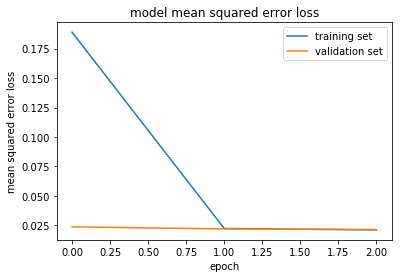

In [6]:
# This is a regression network

# here we do two preprocessing
# (1) normalize the data
# (2) mean centering the data
input_shape = (160, 320, 3)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
model.add(Cropping2D(cropping=((65, 25), (0, 0))))  # , input_shape=input_shape
model.add(Conv2D(24, kernel_size=(5, 5),
                activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(36, kernel_size=(5, 5),
                activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(48, kernel_size=(5, 5),
                activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3, 3),
                activation='elu'))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Flatten())
model.add(Dense(1164, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

# print(model.summary())


model.compile(loss='mse', optimizer='adam')

# model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.2, shuffle=True)


steps_per_epoch = int(len(train_samples)/32)
validation_steps =  int(len(validation_samples)/32)

history_object = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=3, verbose=1,
                    validation_data=validation_generator, validation_steps=validation_steps)
model.save('model.h5')

# print the kets contained in the history object
print(history_object.history.keys())

# print the trainning and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()